In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
from pynwb import NWBHDF5IO, NWBFile, TimeSeries
from ipfx.dataset.create import create_ephys_data_set
from ipfx.data_set_features import extract_data_set_features
from ipfx.utilities import drop_failed_sweeps
import ipfx


In [4]:
# load in swc file from patch_seq morph

ID = 623434306

metadata_file = '/Users/elena.westeinde/Datasets/patch_seq/specimen_metadata/20200711_patchseq_metadata_mouse.csv'
metadata = pd.read_csv(metadata_file)

metadata_cell = metadata[metadata['cell_specimen_id'] == ID]
ephys_ID = metadata_cell['ephys_session_id'].values[0]
metadata_cell.head()

,project,cell_specimen_id,cell_specimen_name,hemisphere,structure,donor_id,donor_name,biological_sex,age,ethnicity,...,apical_dendrite_status,neuron_reconstruction_type,cell_soma_normalized_depth,depth_from_pia_um,ephys_session_id,transcriptomics_sample_id,transcriptomics_batch,T-type Accession ID,T-type Label,MET-type Label
23,mIVSCC-MET,623434306,Sst-IRES-Cre;Ai14-346780.04.02.02,right,VISp2/3,346780,Sst-IRES-Cre;Ai14-346780,M,P50,NaN,...,NaN,full,0.231417,NaN,623434287,SM-GE62S_S111_E1-50,RSC-122,CS180626100032,Sst Tac1 Htr1d,Sst-MET-2


In [5]:

data_path = '/Users/elena.westeinde/Datasets/patch_seq/electrophysiology'
data_folder = 'sub-' + str(ID)
# dir_path = os.path.join(data_path, data_folder)
# dir_files = os.listdir(dir_path)
# print(dir_files)

def find_files(substring, directory):
    matching_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if substring in file:
                matching_files.append(os.path.join(root, file))
    return matching_files

matching_files = find_files(str(ephys_ID), data_path)
print(matching_files)

data_set = create_ephys_data_set(nwb_file = matching_files[0])
drop_failed_sweeps(data_set)

# save data_set


cell_features, sweep_features, cell_record, sweep_records, _, _ = \
    extract_data_set_features(data_set)#, subthresh_min_amp=-100.0)

['/Users/elena.westeinde/Datasets/patch_seq/electrophysiology/sub-617297314/sub-617297314_ses-623434287_icephys.nwb']


/Users/elena.westeinde/miniforge3/envs/allensdk/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/elena.westeinde/miniforge3/envs/allensdk/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [31]:
output_dir = os.path.join('/Users/elena.westeinde/Datasets/processed_ephys', str(ID) + '_ephys_ID_' + str(ephys_ID))
print(output_dir)
print(matching_files[0])

#ipfx.run_pipeline_from_nwb_file(matching_files[0], output_dir)

/Users/elena.westeinde/Datasets/processed_ephys/623434306_ephys_ID_623434287
/Users/elena.westeinde/Datasets/patch_seq/electrophysiology/sub-617297314/sub-617297314_ses-623434287_icephys.nwb


In [7]:
print(cell_features.keys())
print(sweep_features.keys())

dict_keys(['long_squares', 'short_squares', 'ramps'])
dict_keys([4, 5, 6, 7, 8, 9, 11, 12, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])


In [8]:
sweeps = cell_features['long_squares']['sweeps']
sweeps[0].keys()

dict_keys(['avg_rate', 'peak_deflect', 'stim_amp', 'v_baseline', 'sag', 'adapt', 'latency', 'isi_cv', 'mean_isi', 'median_isi', 'first_isi', 'index', 'spikes', 'sweep_number'])

Text(0.5, 1.0, 'Rheobase sweep')

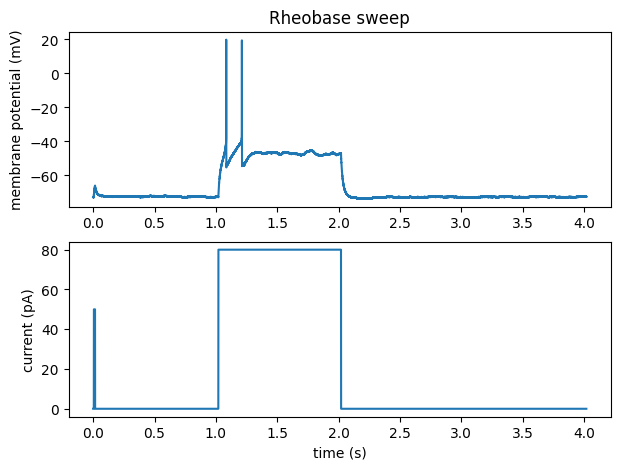

In [9]:
swp = data_set.sweep(cell_features["long_squares"]["rheobase_sweep"]["sweep_number"])
fig, axes = plt.subplots(2, 1, figsize=(7,5))
axes[0].plot(swp.t, swp.v)
#axes[0].set_xlabel("time (s)", fontsize=16)
axes[0].set_ylabel("membrane potential (mV)")
axes[1].plot(swp.t, swp.i)
axes[1].set_ylabel("current (pA)")
axes[1].set_xlabel("time (s)")
axes[0].set_title("Rheobase sweep")

(0.0, 3.0)

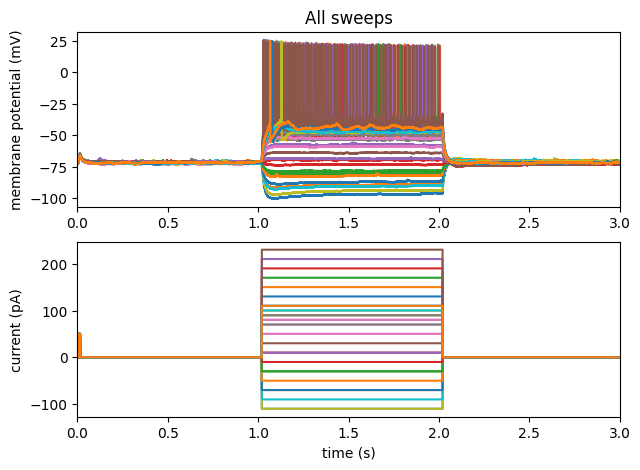

In [10]:
all_swp = data_set.sweep(cell_features['long_squares']['sweeps'][0]['sweep_number'])
# plot all sweeps
fig, axes = plt.subplots(2, 1, figsize=(7, 5))
for sweep_number in range(len(sweeps)):
    swp = data_set.sweep(cell_features['long_squares']['sweeps'][sweep_number]['sweep_number'])
    axes[0].plot(swp.t, swp.v)
    axes[1].plot(swp.t, swp.i)
axes[0].set_ylabel("membrane potential (mV)")
axes[1].set_ylabel("current (pA)")
axes[1].set_xlabel("time (s)")
axes[0].set_title("All sweeps")
axes[0].set_xlim(0, 3.0)
axes[1].set_xlim(0, 3.0)

In [45]:
import json
metadata_path = '/Users/elena.westeinde/Datasets/patch_seq/specimen_metadata/20200711_patchseq_metadata_mouse.csv'
save_dir = '/Users/elena.westeinde/Datasets/raw_ephys'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
metadata = pd.read_csv(metadata_path)
metadata_cell = metadata[metadata['cell_specimen_id'] == ID]
ephys_ID = metadata_cell['ephys_session_id'].values[0]

matching_files = find_files(str(ephys_ID), data_path)
stim_dict = {}
if len(matching_files) == 0:
    print('No matching files found')
   # return None
elif len(matching_files) > 1:
    print('Multiple matching files found')
    #return None
else:
    data_set = create_ephys_data_set(nwb_file = matching_files[0])
    drop_failed_sweeps(data_set)
    cell_features, sweep_features, cell_record, sweep_records, _, _ = \
    extract_data_set_features(data_set)#, subthresh_min_amp=-100.0)
    stim_types = cell_features.keys()
    stim_dict = {stim_type: {} for stim_type in stim_types}

    #for stim_type in stim_types:
    sweeps = cell_features['long_squares']['sweeps']
    for sweep_num in range(len(sweeps)):
        swp = data_set.sweep(cell_features['long_squares']['sweeps'][sweep_num]['sweep_number'])
        stim_dur = 1000 # ms & delay
        v_baseline = cell_features['long_squares']['sweeps'][sweep_num]['v_baseline']
        stim_amp = cell_features['long_squares']['sweeps'][sweep_num]['stim_amp']
        time = swp.t
        current = swp.i
        voltage = swp.v
        stim_dict['long_squares'][sweep_num] = {'time': time.tolist(), 
                                                'current': current.tolist(), 
                                                'voltage': voltage.tolist(),
                                                'stim_dur': stim_dur,
                                                'v_baseline': v_baseline,
                                                'stim_amp': stim_amp}

    file_name = os.path.join(save_dir, str(ID) + '_ephys_ID_' + str(ephys_ID) + '.json')
    # save file
    # with open(file_name, 'w') as f:
    #     json.dump(stim_dict, f)

/Users/elena.westeinde/miniforge3/envs/allensdk/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/elena.westeinde/miniforge3/envs/allensdk/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [47]:
# get stimulus duration and amplitude

cell_features['long_squares']

{'sweeps': [{'avg_rate': 0.0,
   'peak_deflect': (-100.43751, 54228),
   'stim_amp': -110.0,
   'v_baseline': -72.26676940917969,
   'sag': 0.15234233438968658,
   'adapt': nan,
   'latency': nan,
   'isi_cv': nan,
   'mean_isi': nan,
   'median_isi': nan,
   'first_isi': nan,
   'index': 0,
   'spikes': [],
   'sweep_number': 4},
  {'avg_rate': 0.0,
   'peak_deflect': (-91.75, 54722),
   'stim_amp': -70.0,
   'v_baseline': -72.68051147460938,
   'sag': 0.119676373898983,
   'adapt': nan,
   'latency': nan,
   'isi_cv': nan,
   'mean_isi': nan,
   'median_isi': nan,
   'first_isi': nan,
   'index': 1,
   'spikes': [],
   'sweep_number': 5},
  {'avg_rate': 0.0,
   'peak_deflect': (-81.375, 56258),
   'stim_amp': -29.999998092651367,
   'v_baseline': -72.56971740722656,
   'sag': 0.12432820349931717,
   'adapt': nan,
   'latency': nan,
   'isi_cv': nan,
   'mean_isi': nan,
   'median_isi': nan,
   'first_isi': nan,
   'index': 2,
   'spikes': [],
   'sweep_number': 6},
  {'avg_rate': 0.0